# Sonyc Peak Time Truck Detection

**Cowork by Xurui Chen and Pengzi Li**

[Peak Time Detection](#Peak_Time_Detection)

[Get Moving Window](#Get_Moving_Window)

[Data Filter](#Data_Filter)

[Abnormal Detection](#Abnormal_Detection)

In [1]:
import pandas as pd
import numpy as np
import utils
import matplotlib as plt
import seaborn as sns
import matplotlib.ticker as ticker
import ipywidgets as widgets
import matplotlib.dates as mdates
from datetime import datetime
import matplotlib.pyplot as pl

In [2]:
plt.rcParams['timezone'] = 'America/New_York'
df = pd.read_csv('sonycnode-b827eb491436.sonyc.csv')

In [3]:
df['time'] = pd.to_datetime(df['timestamp'].values.astype(np.int64), unit='s')
df['time'] = df['time'].dt.tz_localize('UTC').dt.tz_convert('America/New_York')
df.set_index(pd.DatetimeIndex(df['time']), inplace=True)
df.drop(['time', 'timestamp'], axis=1, inplace=True)

In [4]:
df['weekday'] = df.index.weekday
df['min_of_day'] = (df.index.hour * 60.0) + df.index.minute
df['hour_of_day'] = df.index.hour

In [5]:
df.head()

,dBAS,weekday,min_of_day,hour_of_day
time,,,,
2019-04-11 11:14:09-04:00,64.35,3,674.0,11
2019-04-11 11:14:10-04:00,65.92,3,674.0,11
2019-04-11 11:14:11-04:00,69.24,3,674.0,11
2019-04-11 11:14:12-04:00,71.78,3,674.0,11
2019-04-11 11:14:13-04:00,70.70,3,674.0,11


## Peak_Time_Detection

In [6]:
def calc_leq(data):
    return 10 * np.log10(np.mean(10 ** (data / 10)))

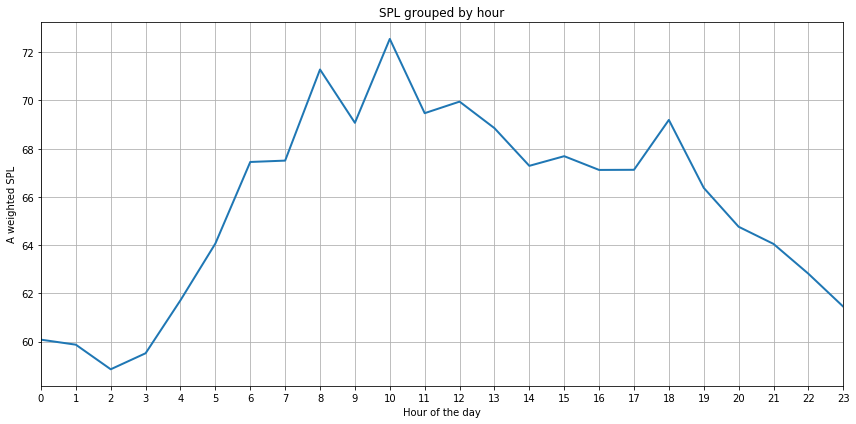

In [7]:
df_gb = df.groupby(df['hour_of_day'])['dBAS'].apply(calc_leq)

pl.figure(figsize=(12,6))
ax = sns.lineplot(x=df_gb.index, y=df_gb, linewidth=2)

pl.xlim([df_gb.index.min(), df_gb.index.max()])
pl.title('SPL grouped by hour')
pl.xlabel('Hour of the day')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
pl.ylabel('A weighted SPL')
pl.tight_layout()
pl.grid()

In [8]:
wkday_df = df.loc[df['weekday'] < 5]
wkend_df = df.loc[df['weekday'] > 4]

Plot the mean dBAS changes through the day weekend vs weekday

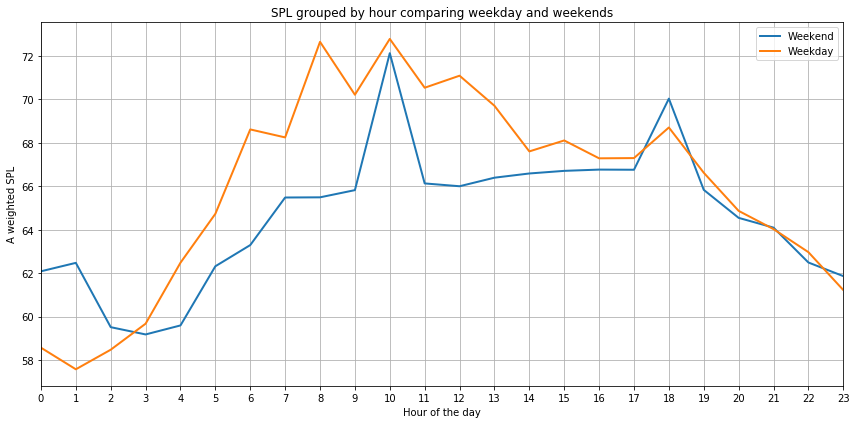

In [9]:
wkend_gb = wkend_df.groupby(wkend_df['hour_of_day'])['dBAS'].apply(calc_leq)
wkday_gb = wkday_df.groupby(wkday_df['hour_of_day'])['dBAS'].apply(calc_leq)

pl.figure(figsize=(12,6))
ax = sns.lineplot(x=wkend_gb.index, y=wkend_gb, linewidth=2)
ax = sns.lineplot(x=wkday_gb.index, y=wkday_gb, linewidth=2)
pl.xlim([wkend_gb.index.min(), wkend_gb.index.max()])
pl.title('SPL grouped by hour comparing weekday and weekends')
pl.xlabel('Hour of the day')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
# ax.axvspan(7, 8, alpha=0.5, color='red')
# ax.axvspan(7, 8, alpha=0.5, color='red')
# ax.axvspan(16, 18, alpha=0.5, color='red')
pl.ylabel('A weighted SPL')
pl.legend(['Weekend', 'Weekday'])
pl.tight_layout()
pl.grid()
#pl.savefig('wkend_wkday_byhour.pdf', format='pdf', dpi=1000, bbox_inches='tight')

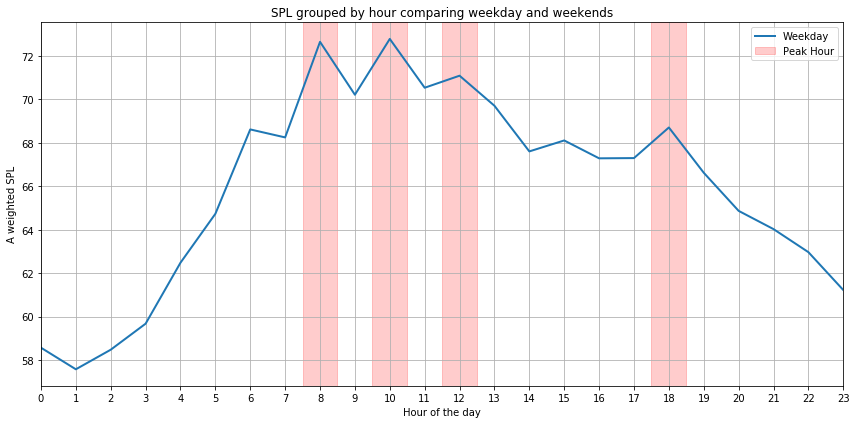

In [10]:
pl.figure(figsize=(12,6))
ax = sns.lineplot(x=wkday_gb.index, y=wkday_gb, linewidth=2)
pl.xlim([wkend_gb.index.min(), wkend_gb.index.max()])
pl.title('SPL grouped by hour comparing weekday and weekends')
pl.xlabel('Hour of the day')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.axvspan(7.5, 8.5, alpha=0.2, color='red')
ax.axvspan(9.5, 10.5, alpha=0.2, color='red')
ax.axvspan(11.5, 12.5, alpha=0.2, color='red')
ax.axvspan(17.5, 18.5, alpha=0.2, color='red')
pl.ylabel('A weighted SPL')
pl.legend(['Weekday', 'Peak Hour'])
pl.tight_layout()
# plt.savefig('wkend_wkday_byhour.pdf', format='pdf', dpi=1000, bbox_inches='tight')
pl.grid()
# pl.savefig('peak hour.jpg')

So we select the 8am, 10am, 12pm and 6pm as morning, midday and afternoon peak time.

And we use 7:50-8:10, 9:50-10:10, 11:50-12:10, 17:50-18:10 to analyze.

## Get_Moving_Window

In [11]:
rolling_mean = df.dBAS.rolling(window=60).mean()
rolling_std = df.dBAS.rolling(window=60).std()

In [12]:
df['rolling_mean'] = rolling_mean
df['rolling_std'] = rolling_std

In [13]:
df.head()

,dBAS,weekday,min_of_day,hour_of_day,rolling_mean,rolling_std
time,,,,,,
2019-04-11 11:14:09-04:00,64.35,3,674.0,11,NaN,NaN
2019-04-11 11:14:10-04:00,65.92,3,674.0,11,NaN,NaN
2019-04-11 11:14:11-04:00,69.24,3,674.0,11,NaN,NaN
2019-04-11 11:14:12-04:00,71.78,3,674.0,11,NaN,NaN
2019-04-11 11:14:13-04:00,70.70,3,674.0,11,NaN,NaN


## Data_Filter

Filter the data with only the peak time range.

In [14]:
print("The minute of 7:50:")
print(pd.to_datetime('2019-04-11 07:50:09').hour * 60.0 + pd.to_datetime('2019-04-11 07:50:09').minute)
print("The minute of 8:10:")
print(pd.to_datetime('2019-04-11 08:10:09').hour * 60.0 + pd.to_datetime('2019-04-11 08:10:09').minute)

The minute of 7:50:
470.0
The minute of 8:10:
490.0


In [15]:
print("The minute of 9:50:")
print(pd.to_datetime('2019-04-11 09:50:09').hour * 60.0 + pd.to_datetime('2019-04-11 09:50:09').minute)
print("The minute of 10:10:")
print(pd.to_datetime('2019-04-11 10:10:09').hour * 60.0 + pd.to_datetime('2019-10-11 08:10:09').minute)


The minute of 9:50:
590.0
The minute of 10:10:
610.0


In [16]:
print("The minute of 11:50:")
print(pd.to_datetime('2019-04-11 11:50:09').hour * 60.0 + pd.to_datetime('2019-04-11 11:50:09').minute)
print("The minute of 12:10:")
print(pd.to_datetime('2019-04-11 12:10:09').hour * 60.0 + pd.to_datetime('2019-04-11 12:10:09').minute)

The minute of 11:50:
710.0
The minute of 12:10:
730.0


In [17]:
print("The minute of 17:50:")
print(pd.to_datetime('2019-04-11 17:50:09').hour * 60.0 + pd.to_datetime('2019-04-11 17:50:09').minute)
print("The minute of 18:10:")
print(pd.to_datetime('2019-04-11 18:10:09').hour * 60.0 + pd.to_datetime('2019-04-11 18:10:09').minute)

The minute of 17:50:
1070.0
The minute of 18:10:
1090.0


In [18]:
am_peak_df1 = df[(df.min_of_day<490) & (df.min_of_day>=470)]
am_peak_df2 = df[(df.min_of_day<610) & (df.min_of_day>=590)]
mid_peak_df = df[(df.min_of_day<730) & (df.min_of_day>=710)]
pm_peak_df = df[(df.min_of_day<1090) & (df.min_of_day>=1070)]

In [19]:
am_peak_df1['peakLable'] = 1
am_peak_df2['peakLable'] = 2
mid_peak_df['peakLable'] = 3
pm_peak_df['peakLable'] = 4

/anaconda3/envs/myEnv3/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/envs/myEnv3/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/envs/myEnv3/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [20]:
peak_df = pd.concat([am_peak_df1, am_peak_df2, mid_peak_df, pm_peak_df])

In [21]:
peak_df.shape

(56389, 7)

In [22]:
peak_df.head()

,dBAS,weekday,min_of_day,hour_of_day,rolling_mean,rolling_std,peakLable
time,,,,,,,
2019-04-12 07:50:00-04:00,73.99,4,470.0,7,66.112333,8.480796,1
2019-04-12 07:50:01-04:00,74.93,4,470.0,7,66.433167,8.443483,1
2019-04-12 07:50:02-04:00,75.38,4,470.0,7,66.763500,8.398471,1
2019-04-12 07:50:03-04:00,76.93,4,470.0,7,67.124167,8.361977,1
2019-04-12 07:50:04-04:00,77.37,4,470.0,7,67.461333,8.360428,1


## Abnormal_Detection

In [23]:
print('')
print('Start: \t %s' % peak_df.index[0])
print('End: \t %s' % peak_df.index[-1])
print('')
print('Total avg SPL: \t %0.2f dBA' % peak_df['dBAS'].mean())
print('Total std SPL: \t %0.2f dBA' % peak_df['dBAS'].std())
print('Total max SPL: \t %0.2f dBA' % peak_df['dBAS'].max())
print('Total min SPL: \t %0.2f dBA' % peak_df['dBAS'].min())


Start: 	 2019-04-12 07:50:00-04:00
End: 	 2019-04-22 18:09:59-04:00

Total avg SPL: 	 62.05 dBA
Total std SPL: 	 6.37 dBA
Total max SPL: 	 95.34 dBA
Total min SPL: 	 46.03 dBA


From overall average and standard deviation, we assume that if the noise higher 3 moving_std than this window time moving_avg, there is a truck pass by.

In [24]:
def truckDetection(df):
    return(df[(df['dBAS'] - df['rolling_mean']> 3*df['rolling_std'])])

In [25]:
truckNoisePoint = truckDetection(peak_df)

In [26]:
truckNoisePoint.shape

(568, 7)

In [27]:
truckNoisePoint.head()

,dBAS,weekday,min_of_day,hour_of_day,rolling_mean,rolling_std,peakLable
time,,,,,,,
2019-04-12 07:56:59-04:00,67.71,4,476.0,7,57.541167,2.985947,1
2019-04-12 07:57:00-04:00,71.44,4,477.0,7,57.791500,3.479230,1
2019-04-12 07:57:01-04:00,69.49,4,477.0,7,57.988500,3.792743,1
2019-04-12 07:58:11-04:00,72.21,4,478.0,7,60.332333,3.762029,1
2019-04-12 07:58:12-04:00,75.11,4,478.0,7,60.618833,4.203820,1


Analyze by each day and each peak time.

In [28]:
truckNoisePoint['Date'] = truckNoisePoint.index.to_frame()['time'].apply(lambda x: x.date())

/anaconda3/envs/myEnv3/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [45]:
truckCount = truckNoisePoint.groupby(['Date', 'peakLable','weekday']).size().to_frame().rename(columns = {0: 'TruckCount'})

In [46]:
truckCount = truckCount.reset_index()

In [47]:
truckCount

,Date,peakLable,weekday,TruckCount
0,2019-04-11,3,3,9
1,2019-04-11,4,3,4
2,2019-04-12,1,4,10
3,2019-04-12,2,4,24
4,2019-04-12,3,4,6
5,2019-04-12,4,4,6
6,2019-04-13,1,5,33
7,2019-04-13,2,5,4
8,2019-04-13,3,5,6
9,2019-04-13,4,5,11


Plot the Truck count by each peak Time at each record day

In [48]:
truckCount = truckCount.set_index('Date')

In [61]:
truckCount1 = truckCount[truckCount['peakLable'] == 1][['TruckCount']].reset_index()
truckCount2 = truckCount[truckCount['peakLable'] == 2][['TruckCount']].reset_index()
truckCount3 = truckCount[truckCount['peakLable'] == 3][['TruckCount']].reset_index()
truckCount4 = truckCount[truckCount['peakLable'] == 4][['TruckCount']].reset_index()

In [62]:
truckCount2

,Date,TruckCount
0,2019-04-12,24
1,2019-04-13,4
2,2019-04-14,22
3,2019-04-15,12
4,2019-04-16,12
5,2019-04-17,5
6,2019-04-18,27
7,2019-04-19,5
8,2019-04-20,1
9,2019-04-21,19


In [63]:
truckCountLabel = truckCount1.merge(truckCount2, left_on = 'Date', right_on = 'Date', how = 'outer') \
.rename(columns = {'TruckCount_x': 'TruckCount_1', 'TruckCount_y': 'TruckCount_2'}) \
.merge(truckCount3, left_on = 'Date', right_on = 'Date', how = 'outer').rename(columns = {'TruckCount': 'TruckCount_3'}) \
.merge(truckCount4, left_on = 'Date', right_on = 'Date', how = 'outer').rename(columns = {'TruckCount': 'TruckCount_4'}) \
.reindex([12,0,1,2,3,4,5,6,7,8,9,10,11]).set_index('Date')

In [64]:
truckCountLabel

,TruckCount_1,TruckCount_2,TruckCount_3,TruckCount_4
Date,,,,
2019-04-11,NaN,NaN,9.0,4.0
2019-04-12,10.0,24.0,6.0,6.0
2019-04-13,33.0,4.0,6.0,11.0
2019-04-14,23.0,22.0,4.0,7.0
2019-04-15,15.0,12.0,NaN,7.0
2019-04-16,5.0,12.0,15.0,8.0
2019-04-17,17.0,5.0,15.0,13.0
2019-04-18,16.0,27.0,2.0,4.0
2019-04-19,24.0,5.0,4.0,4.0


In [65]:
truckCountLabel.rename(columns = {"TruckCount_1":"7:50-8:10","TruckCount_2":"9:50-10:10",
                                 "TruckCount_3":"11:50-12:10","TruckCount_4":"17:50-18:10"}, inplace=True)
truckCountLabel.head()

,7:50-8:10,9:50-10:10,11:50-12:10,17:50-18:10
Date,,,,
2019-04-11,NaN,NaN,9.0,4.0
2019-04-12,10.0,24.0,6.0,6.0
2019-04-13,33.0,4.0,6.0,11.0
2019-04-14,23.0,22.0,4.0,7.0
2019-04-15,15.0,12.0,NaN,7.0


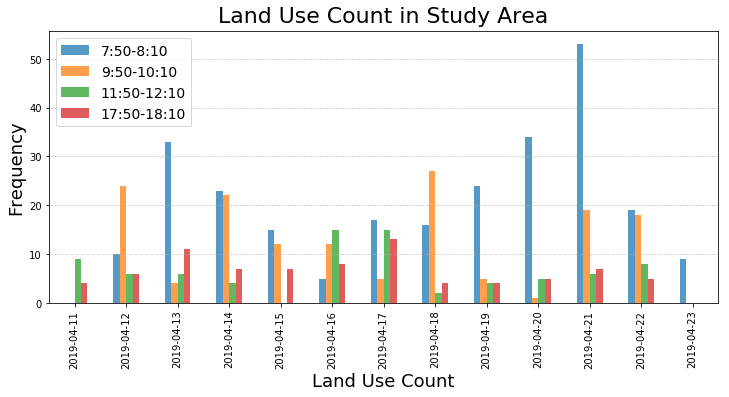

In [38]:
fig = pl.figure(figsize = (12,5))
ax = fig.add_subplot(111)

truckCountLabel.plot.bar( alpha=0.75, ax=ax)

ax.set_title("Land Use Count in Study Area", fontsize=22, y=1.01)
ax.set_xlabel("Land Use Count", fontsize=18)
ax.set_ylabel("Frequency", fontsize=18)


pl.grid(linewidth=0.5, axis='y', linestyle='-.')
pl.legend(fontsize=14)
pl.show()

In [68]:
truckCountLabel.reset_index(inplace=True)

In [69]:
type(truckCountLabel['Date'][2])

datetime.date

In [70]:
truckCountLabel['Weekday'] = truckCountLabel.Date.apply(lambda x: x.weekday())

In [71]:
truckCountLabel

,Date,7:50-8:10,9:50-10:10,11:50-12:10,17:50-18:10,Weekday
0,2019-04-11,NaN,NaN,9.0,4.0,3
1,2019-04-12,10.0,24.0,6.0,6.0,4
2,2019-04-13,33.0,4.0,6.0,11.0,5
3,2019-04-14,23.0,22.0,4.0,7.0,6
4,2019-04-15,15.0,12.0,NaN,7.0,0
5,2019-04-16,5.0,12.0,15.0,8.0,1
6,2019-04-17,17.0,5.0,15.0,13.0,2
7,2019-04-18,16.0,27.0,2.0,4.0,3
8,2019-04-19,24.0,5.0,4.0,4.0,4
9,2019-04-20,34.0,1.0,5.0,5.0,5


In [79]:
type(truckCountLabel.Weekday[2])

numpy.int64

In [80]:
truckCountLabel['Weekday'] = truckCountLabel['Weekday'].replace(0,"Monday")
truckCountLabel['Weekday'] = truckCountLabel['Weekday'].replace(1,"Tuesday")
truckCountLabel['Weekday'] = truckCountLabel['Weekday'].replace(2,"Wednesday")
truckCountLabel['Weekday'] = truckCountLabel['Weekday'].replace(3,"Thursday")
truckCountLabel['Weekday'] = truckCountLabel['Weekday'].replace(4,"Friday")
truckCountLabel['Weekday'] = truckCountLabel['Weekday'].replace(5,"Saturday")
truckCountLabel['Weekday'] = truckCountLabel['Weekday'].replace(6,"Sunday")

In [82]:
truckCountLabel.head()

,Date,7:50-8:10,9:50-10:10,11:50-12:10,17:50-18:10,Weekday
0,2019-04-11,NaN,NaN,9.0,4.0,Thursday
1,2019-04-12,10.0,24.0,6.0,6.0,Friday
2,2019-04-13,33.0,4.0,6.0,11.0,Saturday
3,2019-04-14,23.0,22.0,4.0,7.0,Sunday
4,2019-04-15,15.0,12.0,NaN,7.0,Monday


In [87]:
truckCountLabelWeekday = truckCountLabel[["Weekday","7:50-8:10","9:50-10:10","11:50-12:10","17:50-18:10"]]
truckCountLabelWeekday = truckCountLabelWeekday.groupby('Weekday').sum()

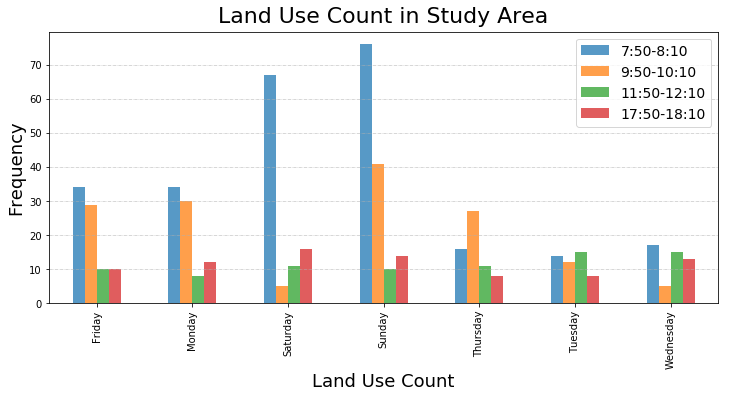

In [88]:
fig = pl.figure(figsize = (12,5))
ax = fig.add_subplot(111)

truckCountLabelWeekday.plot.bar(alpha=0.75, ax=ax)

ax.set_title("Land Use Count in Study Area", fontsize=22, y=1.01)
ax.set_xlabel("Land Use Count", fontsize=18)
ax.set_ylabel("Frequency", fontsize=18)


pl.grid(linewidth=0.5, axis='y', linestyle='-.')
pl.legend(fontsize=14)
pl.show()